# Отчетность по банковским резервам

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import date, timedelta


In [2]:
df    = pd.read_csv('C:/Users/D.Elistratov/Documents/AD3.0/Финальные кейсы/Кейс 2. Отчетность по банковским резервам/Client_Data_01082022.csv', sep=';')
df_bc = pd.read_csv('C:/Users/D.Elistratov/Documents/AD3.0/Финальные кейсы/Кейс 2. Отчетность по банковским резервам/bucket_coeff.csv', sep=';')
df_ct = pd.read_csv('C:/Users/D.Elistratov/Documents/AD3.0/Финальные кейсы/Кейс 2. Отчетность по банковским резервам/credit_type.csv', sep=';')

##################

df_bc_act = df_bc[df_bc['valid_to']=='01.01.3000']

In [3]:
today = pd.to_datetime('2022-08-01')
df['last_inst_payment'] = pd.to_datetime(df['last_inst_payment'],format='%d.%m.%Y')

########################################################

df = df.merge(df_ct, on = 'id_credit_type')

In [39]:
def calc_reserves(df, date_calc):
    
    df['dpd'] = (date_calc - df['last_inst_payment'])/np.timedelta64(1, 'D')
    
    df['id_bucket'] = np.where(df['dpd']<=15,1,
                  np.where(df['dpd']<=30,2,
                  np.where(df['dpd']<=60,3,
                  np.where(df['dpd']<=90,4,
                  np.where(df['dpd']<=120,5,
                  np.where(df['dpd']<=150,6,
                  np.where(df['dpd']<=180,7,8
                          )))))))
    
    df = df.merge(df_bc_act, on = 'id_bucket', how='left')
    
    df['coeff'] = df['coeff'].str.replace(',', '.').astype(float)
    df['amt_res'] = df['amt_instalment'] * df['coeff']

    df_gr = df.groupby(['range_bucket','name_credit_type']).agg({'amt_res':'sum','id_credit':'count','amt_instalment':'sum'}).reset_index()
    
    df_gr['credit_type_name_agg'] = np.where(df_gr['name_credit_type'].str.contains('POS'),'POS',
                  np.where(df_gr['name_credit_type'].str.contains('RC'),'RC',
                  np.where(df_gr['name_credit_type'].str.contains('Autocredit'),'Autocredit','Cash-in'
                          )))
    
    #print(df['amt_res'].sum())
    return df_gr

In [40]:
date_calc1 = pd.to_datetime('2022-08-01')
date_calc2 = pd.to_datetime('2022-08-30')

delta_dates = date_calc2 - date_calc1

In [41]:
dd = date_calc1
df_gr = pd.DataFrame()

for i in range(int(delta_dates/np.timedelta64(1, 'D'))):
    
    dff = df
    dd = dd + timedelta(days=1)
    df_gr_loc = calc_reserves(dff, dd)
    df_gr_loc['date_calc'] = dd
    df_gr = df_gr.append(df_gr_loc)


In [42]:
df_gr_fin = df_gr.groupby('date_calc').sum()['amt_res'].reset_index()
df_gr_fin_pr = df_gr.groupby(['date_calc','credit_type_name_agg']).sum()['amt_res'].reset_index()

In [44]:
df_gr_fin_pr

,date_calc,credit_type_name_agg,amt_res
0,2022-08-02,Autocredit,3999733.11
1,2022-08-02,Cash-in,1441825.85
2,2022-08-02,POS,5741962.19
3,2022-08-02,RC,5753792.24
4,2022-08-03,Autocredit,4022413.91
...,...,...,...
111,2022-08-29,RC,6841984.71
112,2022-08-30,Autocredit,4712949.39
113,2022-08-30,Cash-in,1742026.90
114,2022-08-30,POS,6840946.09


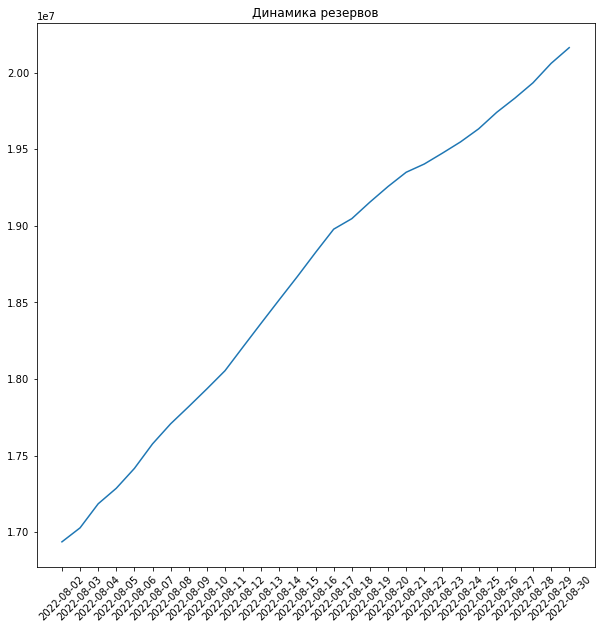

In [43]:
plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(df_gr_fin['date_calc'], df_gr_fin['amt_res'])
plt.xticks(df_gr_fin['date_calc'], rotation = 45)
plt.title('Динамика резервов')
plt.show()

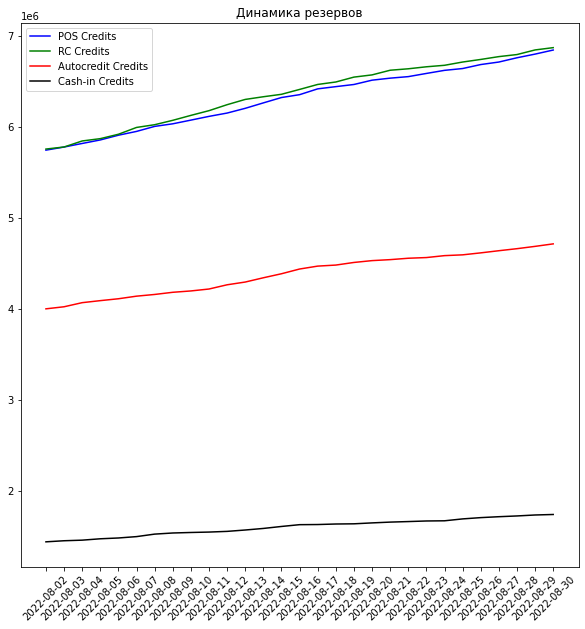

In [46]:
plt.figure()
plt.rcParams["figure.figsize"] = (10,10)

ax.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='POS']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='POS']['amt_res'], label='POS Credits', color = 'blue')
ax.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='RC']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='RC']['amt_res'], label='RC Credits', color = 'green')
ax.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Autocredit']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Autocredit']['amt_res'], label='Autocredit Credits', color = 'red')
ax.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Cash-in']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Cash-in']['amt_res'], label='Cash-in Credits', color = 'black')

plt.xticks(df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='POS']['date_calc'], rotation = 45)
plt.title('Динамика резервов')
plt.legend(loc='upper left')
plt.show()